# AirAsia Assessment

In [2]:
# configs
fp_data = 'data/AncillaryScoring_insurance.csv'
fp_encoder = 'encoder/encoder.pickle'

In [3]:
import pandas as pd
import pickle
from sklearn.preprocessing import OneHotEncoder

In [5]:
def load_airline_data(fp):
    df = pd.read_csv(fp, encoding='unicode_escape')

    # drop redundant row
    df = df[df.columns.drop('Id')]

    return df

def process_airline_data(df, fp, train_encoding=False):
    # retain only top 10 countries
    top_10 = df.geoNetwork_country.value_counts().head(10).index.to_list()
    is_top_10 = df.geoNetwork_country.isin(top_10)
    df.loc[~is_top_10, 'geoNetwork_country'] = 'Others'

    # remove columns
    cols_drop = [
        'ROUTE'         # high cardinality
        ]
    df = df[df.columns.drop(cols_drop)]

    # encode features
    # enumerate categorical columns
    cat_cols = ["SALESCHANNEL", "TRIPTYPEDESC", "flight_day", "geoNetwork_country"]

    df_cat = df[cat_cols]

    if train_encoding:     
        # Instantiating the Scikit-Learn OHE object
        ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
        
        # Fitting the DataFrame to the Scikit-Learn one-hot encoder
        dummies = ohe.fit_transform(df_cat)

        # save trained encoder for future use
        with open(fp, 'wb') as f:
            pickle.dump(ohe, f)

    else:
        # load pickled encoder
        with open(fp, 'rb') as f:
            ohe = pickle.load(f)
            
        dummies = ohe.transform(df_cat)
        
    # Using the output dummies and transformer categories to produce a cleaner looking dataframe
    dummies_df = pd.DataFrame(dummies)
    dummies_df.columns = ohe.get_feature_names_out()

    numeric_df = df.drop(cat_cols, axis=1).reset_index(drop=True)

    df = pd.concat([dummies_df, numeric_df], axis=1)

    return df

In [6]:
df = load_airline_data(fp_data)
df_final = process_airline_data(df, fp_encoder, train_encoding=True)

In [7]:
df_final

,SALESCHANNEL_Mobile,TRIPTYPEDESC_OneWay,TRIPTYPEDESC_RoundTrip,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,geoNetwork_country_China,...,geoNetwork_country_Thailand,PAXCOUNT,PURCHASELEAD,LENGTHOFSTAY,flight_hour,BAGGAGE_CATEGORY,SEAT_CATEGORY,FNB_CATEGORY,INS_FLAG,flightDuration_hour
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2,262,19,7,1,0,0,0,5.52
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,112,20,3,0,0,0,0,5.52
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2,243,22,17,1,1,0,0,5.52
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,96,31,4,0,0,1,0,5.52
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2,68,22,15,1,0,1,0,5.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2,27,6,9,1,0,1,0,5.62
49996,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1,111,6,4,0,0,0,0,5.62
49997,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,24,6,22,0,0,1,0,5.62
49998,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,15,6,11,1,0,1,0,5.62


In [8]:
df.groupby(['BAGGAGE_CATEGORY','SEAT_CATEGORY', 'FNB_CATEGORY'])\
    .agg({'PAXCOUNT': 'count',
          'PURCHASELEAD': 'mean',
          'flight_hour': 'mean',
          'PAXCOUNT': 'mean',
          'flightDuration_hour': 'mean',
          'LENGTHOFSTAY': 'mean',
          'INS_FLAG': 'mean'}).reset_index().sort_values('PAXCOUNT', ascending=False)

,BAGGAGE_CATEGORY,SEAT_CATEGORY,FNB_CATEGORY,PAXCOUNT,PURCHASELEAD,flight_hour,flightDuration_hour,LENGTHOFSTAY,INS_FLAG
6,1,1,0,1.775715,94.885942,8.971706,7.390946,21.329207,0.183319
5,1,0,1,1.698120,86.697996,9.082784,7.527287,30.337109,0.150629
7,1,1,1,1.675143,80.491220,9.195667,7.629143,29.948119,0.185975
4,1,0,0,1.641849,80.703466,8.884996,7.015957,25.132523,0.159329
0,0,0,0,1.451076,91.857102,9.127977,7.048469,14.715830,0.106743
1,0,0,1,1.378252,78.794797,9.101432,7.391494,15.990061,0.120725
3,0,1,1,1.338041,80.747573,9.380406,7.483831,12.311562,0.153575
2,0,1,0,1.327320,85.410438,9.282861,7.124188,11.713918,0.130155


minor notes:  
  
-combinations with seat category are least pppular

In [9]:
df.groupby(['SALESCHANNEL', 'TRIPTYPEDESC'])\
    .agg({'PAXCOUNT': 'count',
          'PURCHASELEAD': 'mean',
          'flight_hour': 'mean',
          'PAXCOUNT': 'mean',
          'flightDuration_hour': 'mean',
          'LENGTHOFSTAY': 'mean',
          'INS_FLAG': 'mean'}).reset_index().sort_values('PAXCOUNT', ascending=False)

,SALESCHANNEL,TRIPTYPEDESC,PAXCOUNT,PURCHASELEAD,flight_hour,flightDuration_hour,LENGTHOFSTAY,INS_FLAG
2,Internet,RoundTrip,1.592287,85.270700,9.020432,7.290837,23.809594,0.155942
5,Mobile,RoundTrip,1.585239,81.678342,9.411365,7.115645,17.343996,0.108470
1,Internet,OneWay,1.579946,94.704607,9.317073,8.003225,18.750678,0.048780
0,Internet,CircleTrip,1.571429,94.205357,9.160714,7.834911,25.660714,0.044643
3,Mobile,CircleTrip,1.500000,125.750000,9.500000,5.802500,13.000000,0.000000
4,Mobile,OneWay,1.277778,26.833333,7.944444,7.219444,3.388889,0.111111


minor notes:  
  
-less insurance for non-roundtrip flights  
-majority of trips are roundtrips  
-Internet is still the dominant booking method

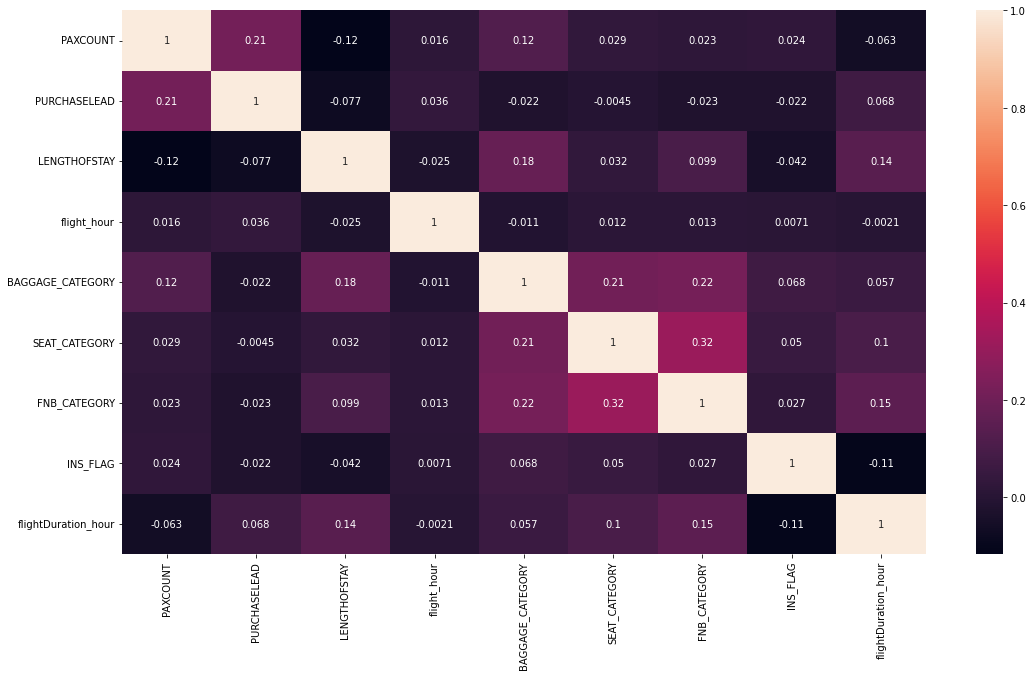

In [11]:
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline
plt.rcParams["figure.figsize"] = [18, 10]

corrMatrix = df.corr()
plt.figure(figsize=(18,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()

## Model Development

In [12]:
import xgboost as xgb

In [13]:
df_final.head()

,SALESCHANNEL_Mobile,TRIPTYPEDESC_OneWay,TRIPTYPEDESC_RoundTrip,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,geoNetwork_country_China,...,geoNetwork_country_Thailand,PAXCOUNT,PURCHASELEAD,LENGTHOFSTAY,flight_hour,BAGGAGE_CATEGORY,SEAT_CATEGORY,FNB_CATEGORY,INS_FLAG,flightDuration_hour
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2,262,19,7,1,0,0,0,5.52
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,112,20,3,0,0,0,0,5.52
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2,243,22,17,1,1,0,0,5.52
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,96,31,4,0,0,1,0,5.52
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2,68,22,15,1,0,1,0,5.52


In [14]:
X = df_final.drop('INS_FLAG', axis=1)
y = df_final['INS_FLAG']

In [15]:
# create test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 27)
(40000,)
(10000, 27)
(10000,)


In [16]:
from sklearn.model_selection import GridSearchCV

# hyperparameters for Grid Search
params = { 'max_depth': [3,7,10],
           'objective': ["binary:logistic"],
           'learning_rate': [0.01, 0.05, 0.1],
           'colsample_bytree': [0.3, 0.7, 1],
           'scale_pos_weight': [1,3,5]}

# instantiate classifier with hyper parameters
xg_class = xgb.XGBClassifier(tree_method='gpu_hist', seed=123)

# grid search with cross validation for accurate and robust models
clf = GridSearchCV( estimator=xg_class,
                    param_grid=params,
                    cv=3,
                    n_jobs=-1,
                    scoring='recall',
                    verbose=1, refit=True)

In [25]:
# fit classifier to training set and predict using btest set
clf.fit(X_train,y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                        

#### Model Fit

in fitting the model, i chose recall as scoring metric for hyperparameter search as the problem statment would want to prioritize identifying all the individuals that are likely to avail of insurance. False positives are not expensive in this scenario.

In [26]:
# model training
print("Best parameters:", clf.best_params_)
print("Best recall: ", (clf.best_score_))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'binary:logistic', 'scale_pos_weight': 5}
Best recall:  0.6503399086147331


In [17]:
# fit best model
best_model = xgb.XGBClassifier(**clf.best_params_)
best_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

#### Performance on Test Set

In [18]:
preds = best_model.predict(X_test)
pred_proba = best_model.predict_proba(X_test)[::,1]

In [19]:
y_test.value_counts()

0    8505
1    1495
Name: INS_FLAG, dtype: int64

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


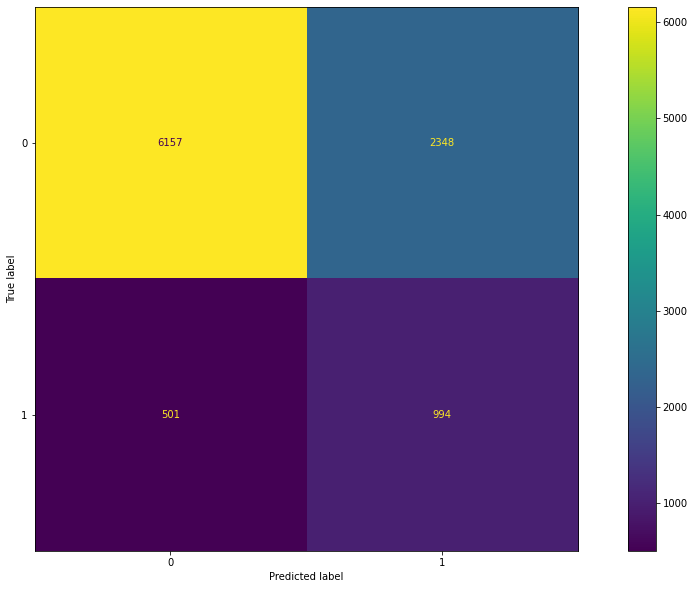

In [20]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# f1 score for model
f1_score = f1_score(y_test, preds)

# roc curve for model
fpr, tpr, thresh1 = roc_curve(y_test, pred_proba, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc scores
auc_score = roc_auc_score(y_test, pred_proba)

plot_confusion_matrix(best_model, X_test, y_test)
plt.show()

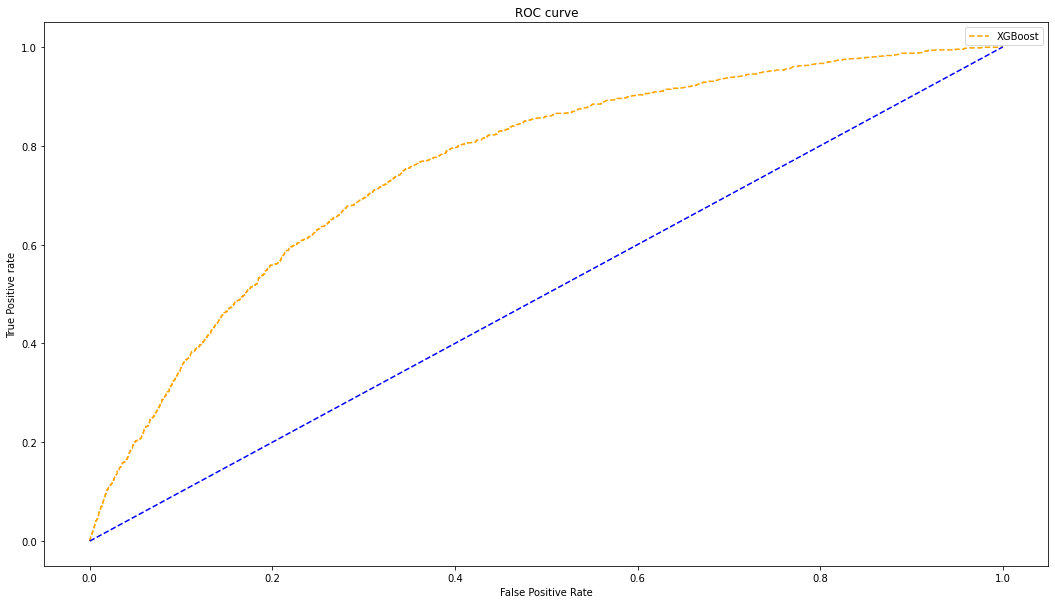

AUC=0.7586495057992643


In [21]:
# matplotlib
import matplotlib.pyplot as plt


# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBoost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

print("AUC="+str(auc_score))

## Analytical Story

In [22]:
import shap
shap.initjs()

# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

### Feature Importance

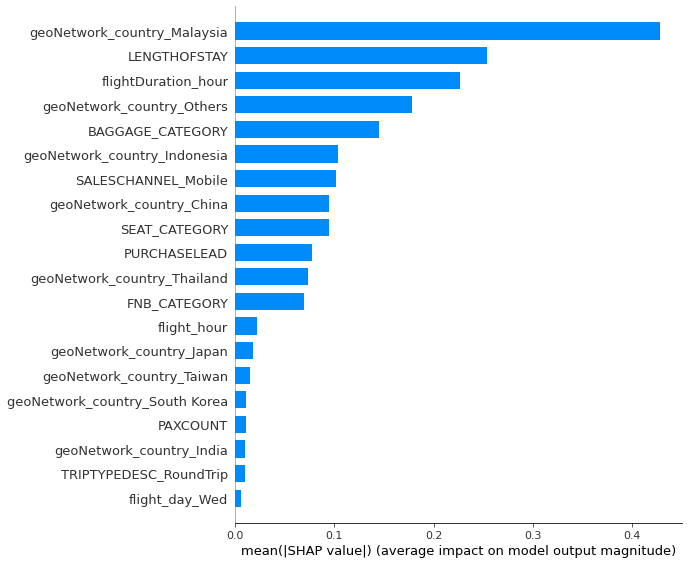

In [24]:
shap.summary_plot(shap_values, X, plot_type="bar")

According to the feature importance plot, having the flight in malaysia had the biggest impact on the likelihood of an individual to take insurance. Given these first impressions, personally, I find it interesting that the model suggests that the likelihood to avail of insurance is affected by the **country, length of flight, other services they avail, and the sales channel they booked through**. Importance of these features are plotted in decreasing magnitude above. The direction and values that affect the prediction will be investigated further below. 

### Interesting Findings

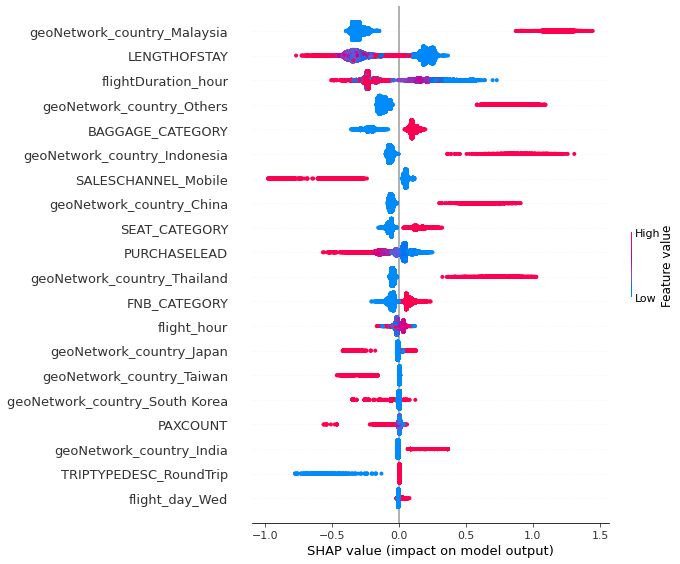

In [25]:
shap.summary_plot(shap_values, X)

Interesting findings:  

1. The direction of the plots above indicate that for countries like malaysia, indonesia, china, india (slightly), and other auxiliary countries not in the top 10 serviced countries have higher likelihoods to book insurance compared to other countries. There also may be countries averse to insurance like japan, taiwan, south korea.  

2. Participation in other ancilliary services (baggage, seat, fnb) indicate a higher likelihood to participate in insurance as well across the board. Which could indicate a consumer profile that separates those who prefer traveling as cheaply as possible to those who avail of extra services.  

3. The sales channel they go through affects their likelihood to participate in insurance. Mobile phone bookers are indicated to be less likely to participate in the services so improving in that platform could be a priority in the future.  

4. Individuals that book flights earlier on are less likely to participate in extra services. My initial assessment of this is that these could be the people who book flights early in order to save money on ticket prices and these extra services would not a priority for that profile. The late bookers could be more of the consumers that prefer convenience without minding paying a little extra for extra comforts. This could also reflect on the nature of the trip. Business trips could tend to make themselves urgent and sporadic as personal trips would more readily planned ahead, these assumptions needs further research of course.

### Investigate Breakpoints/Thresholds

the plots below investigate thresholds or breakpoints that could drastically change customer behavior.

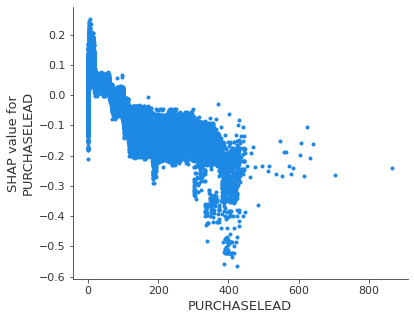

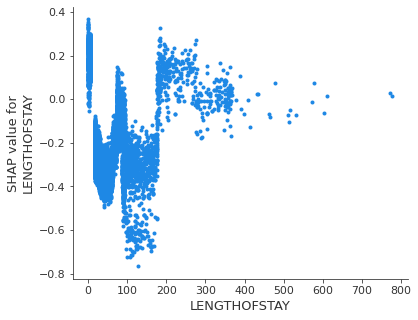

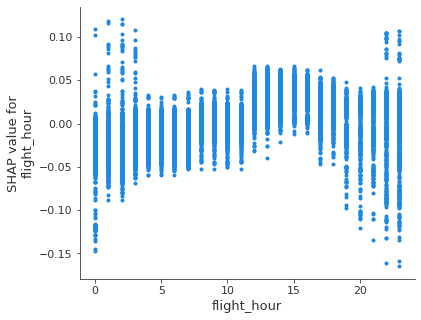

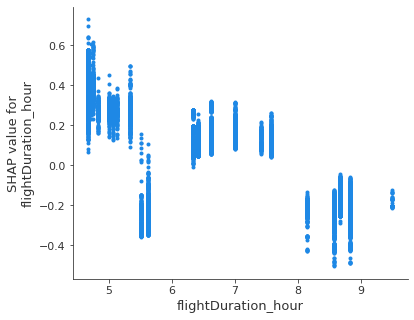

In [33]:
numerical_cols = ['PURCHASELEAD', 'LENGTHOFSTAY', 'flight_hour', 'flightDuration_hour']

for name in numerical_cols:
    shap.dependence_plot(name, shap_values, X, display_features=X, interaction_index=None)

1. consistent with earlier impressions people that have small purchase lead times gravitate to buying insurance more. the plot starts dipping towards the negative direction at around 100 days, so people who book 3+ months in advance could be people we can differentiate.  

2. there is no clear pattern with the lenght of stay variable  

3. bookings towards the offhours see a decrease in likelihood to buy insurance.  

4. interestingly for longer flights, the model indicates that people were less likely to purchase insurance. Maybe due to the likely higher costs associated with the flights as well as the possibly lower frequency of long distance flights that an individual would take giving the feeling that they are not constantly exposed to flight risks.

## Deployment Design

1. As a good general solution (solution scalable to many countries) and heuristic, I would recommend **focusing on the individuals that book early** indicated by the model to have a breakpoint at around 100 days (further research required). Targetting these individuals with promos for discounts for early insurance when they land on the platforms and also when they are checking out.  

2. Deploying the model as an API, once the features are captured from the individual from **website cookies, account information and booking details**, their likelihood to participate in insurance can be calculated and depending on the results, individuals with lower likelihoods could be enticed with more advertisments for insurance, possibly some discounts, or tailored products that could address their customer segments once the models been studied more thoroughly.

## Testing

Based on the model findings above I would perform stratified sampling to generate a population that would encapsulate and generalize to the major proportion of the population that is indicated here. For example ensuring that there are a proportionate level of individuals from countries with increased/decreased likelihoods towards insurance, early/late bookers, and availment of other ancillary services. Making sure that there is a representative sample in each of these substratas would go a long way to ensuring the validity of the test when scaled, since theres been evidence to suggest that these are the factors that separate customer behavior. Then after matching their propensities to buy insurance we can A/B test the model and associated services and monitor the results over an adequate period to capture some seasonality. A good rule of thumb would be a month to capture behaviours throughout the months cycle. Once the results are in we can statistically determine the significance of the effect that our model creates on insurance availment and confidently present it as effective/not.